<a href="https://colab.research.google.com/github/Iterb/Human-interaction-recognition/blob/main/Preprocess_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment setup

## Install OpenPose

In [ ]:
import os
from os.path import exists, join, basename, splitext
#http://rose1.ntu.edu.sg/datasets/actionrecognition.asp
git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if True:
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
  
from IPython.display import YouTubeVideo

Selecting previously unselected package libgflags2.2.
(Reading database ... 146442 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selecting previously unselected package libleveldb1v5:amd64.
Preparing to unpack ...

## Mount Google Drive

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Main imports

In [154]:
import pandas as pd
import numpy as np
from statistics import mean
import math

# Joint features
Load joint data extracted by OpenPose form NTU dataset 

Input data is in format 
(x,y,c) for each of 25 joints concatenated for 2 people. 

In [175]:
full_data = pd.read_csv(r'./drive/MyDrive/OpenPose/full_data.csv')

x = full_data.drop(["class"],axis=1)
y = full_data["class"].values

print('size of x = ',x.shape)
print('size of y = ',y.shape)

x_data_not_normalized = x.copy
y_data_not_normalized = y.copy

size of x =  (6708, 150)
size of y =  (6708,)


Removing c detection confidence values

In [176]:
x  = x.drop(x.columns[2::3], axis=1)

Spliting data

In [12]:
x_per1 = x.drop(x.columns[50:], axis=1)
x_per2 = x.drop(x.columns[:50], axis=1)

In [13]:
x_coords_per1 = []
for x in x_per1.to_numpy():
  it = iter(x)
  joint_coords = list(zip(it,it))
  x_coords_per1.append(joint_coords)
x_coords_per1 = np.array(x_coords_per1)

x_coords_per2 = []
for x in x_per2.to_numpy():
  it = iter(x)
  joint_coords = list(zip(it,it))
  x_coords_per2.append(joint_coords)
x_coords_per2 = np.array(x_coords_per2)

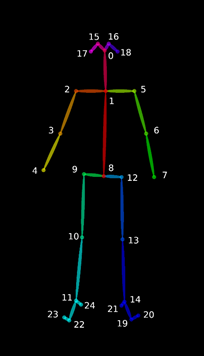

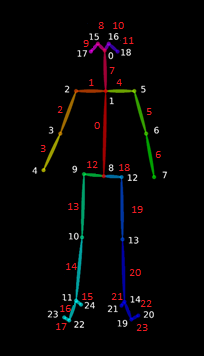

In [203]:
def calculate_angle(a, b, c):
  ba = a - b
  bc = c - b
  cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
  return np.degrees(np.arccos(cosine_angle))

def calculate_average_limb_lengths(x_coords):
  x_avg_lengths =[[] for i in range(24)]
  norms = []
  x_avg_lengths[0].append(1)
  limbs = [(1,2),(2,3),(3,4),(1,5),(5,6),(6,7),(1,0),(0,15),(15,17),(0,16),(16,18),
           (8,9),(9,10),(10,11),(11,24),(11,23),(22,23),(8,12),(12,13),(13,14),
           (14,21),(14,19),(19,20)]

  for frame in x_coords:
    if (np.any(frame[1] == 0)) or (np.any(frame[8] == 0)):
      continue
    norm = np.linalg.norm(frame[1] - frame[8])
    norms.append(norm)
    l0 = 1
    for i, limb in enumerate(limbs):
      if (np.any(frame[limb[0]] != 0)) and (np.any(frame[limb[1]] != 0)):
        l = np.linalg.norm(frame[limb[0]] - frame[limb[1]]) / norm
        x_avg_lengths[i+1].append(l)

  limb_lengths_average = [sum(col)/len(col) for col in x_avg_lengths]
  norm_average = sum(norms)/len(norms)
  return limb_lengths_average, norm_average

def calculate_joint_lengths(x_coords, average_limbs, average_norm):
  x_lengths = []
  limbs = [(1,2),(2,3),(3,4),(1,5),(5,6),(6,7),(1,0),(0,15),(15,17),(0,16),(16,18),
           (8,9),(9,10),(10,11),(11,24),(11,23),(22,23),(8,12),(12,13),(13,14),
           (14,21),(14,19),(19,20)]
  for frame in x_coords:
    x_person = []
    if (np.any(frame[1] == 0)) or (np.any(frame[8] == 0)):
      norm = average_norm
    else:
      norm = np.linalg.norm(frame[1] - frame[8])

    x_person.append(1)
    for i, limb in enumerate(limbs):
      if (np.any(frame[limb[0]] == 0)) or (np.any(frame[limb[1]] == 0)):
        l = average_limbs[i+1]
        x_person.append(l)
      else:
        l = np.linalg.norm(frame[limb[0]] - frame[limb[1]]) / norm
        x_person.append(l)

    x_lengths.append(x_person)
  return x_lengths

In [207]:
average_limbs, average_norm = calculate_average_limb_lengths(x_coords_per2)

In [210]:
calculate_joint_lengths(x_coords_per2,average_limbs,average_norm)

6708

In [209]:
average_limbs

[1.0,
 0.13367606037873442,
 0.519278482900079,
 0.43338663956682283,
 0.1323191642374672,
 0.5265461734895996,
 0.46075613091669865,
 0.4158089555334167,
 0.06389029544196546,
 0.168617071464401,
 0.07675756347273184,
 0.17686267317653884,
 0.11149202589648263,
 0.7074878176912198,
 0.5244853078920205,
 0.055783058293825946,
 0.1360651261555916,
 0.04751196670265947,
 0.11161906959558221,
 0.7215547261597406,
 0.7666509267831791,
 0.08773467039733286,
 0.2704178072411894,
 0.0554268319424278]

In [188]:
x_coords_per1[2163]

array([[ 22.7017 , 213.173  ],
       [  0.     ,   0.     ],
       [  0.     ,   0.     ],
       [  0.     ,   0.     ],
       [  0.     ,   0.     ],
       [  0.     ,   0.     ],
       [  0.     ,   0.     ],
       [  0.     ,   0.     ],
       [  0.     ,   0.     ],
       [  0.     ,   0.     ],
       [  0.     ,   0.     ],
       [  0.     ,   0.     ],
       [  0.     ,   0.     ],
       [  0.     ,   0.     ],
       [  0.     ,   0.     ],
       [ 16.1838 , 202.79   ],
       [ 26.5523 , 204.09   ],
       [  3.73491, 200.155  ],
       [  0.     ,   0.     ],
       [  0.     ,   0.     ],
       [  0.     ,   0.     ],
       [  0.     ,   0.     ],
       [  0.     ,   0.     ],
       [  0.     ,   0.     ],
       [  0.     ,   0.     ]])

In [55]:
np.linalg.norm(frame[0] - frame[15]) / norm

In [56]:
np.append(c, a, axis=-1)

TypeError: ignored

In [53]:
c

array([array([1, 2, 3]), array([1, 2, 4, 5]), array([1, 2, 4, 5]),
       array([1, 2, 3]), 1, 2, 3], dtype=object)